In [85]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GroupKFold
import matplotlib.pyplot as plt

print("Libraries loaded!")


Libraries loaded!


In [86]:
# Change these paths as needed
comps_df = pd.read_csv('data/model_ready/comps_pairs_model_ready.csv')
candidates_df = pd.read_csv('data/model_ready/candidates_pair_model_ready.csv')
subjects_df = pd.read_csv('data/cleaned/subjects_cleaned.csv')

print("Data loaded!")


Data loaded!


In [87]:
numerical_features = [
    'gla_diff',         # Gross Living Area difference
    'lot_size_diff',    # Lot size difference
    'bedroom_diff',     # Bedroom count difference
    'bathroom_diff',    # Bathroom count difference
    'room_count_diff'   # Total room count difference
]

categorical_features = [
    'same_property_type',   # Same property type (1/0)
    'same_storey_type',     # Same storey type (1/0)
    'sold_recently_90',     # Sold within 90 days (1/0)
]

feature_cols = numerical_features + categorical_features

comps_df['label'] = 1
candidates_df['label'] = 0


In [88]:
# For each subject/orderID, keep all comps and sample 5x negatives
balanced_rows = []

for order_id in comps_df['orderID'].unique():
    pos = comps_df[comps_df['orderID'] == order_id]
    cands = candidates_df[candidates_df['orderID'] == order_id]
    n_pos = len(pos)
    n_neg = min(len(cands), n_pos * 5)  # 5 negatives per positive
    if n_neg > 0:
        sampled_neg = cands.sample(n=n_neg, random_state=42)
        balanced_rows.append(pos)
        balanced_rows.append(sampled_neg)
    else:
        balanced_rows.append(pos)  # If no candidates, just add comps

balanced_data = pd.concat(balanced_rows, ignore_index=True)
balanced_data[feature_cols] = balanced_data[feature_cols].fillna(0)


In [89]:
# Split orderIDs so subjects don't leak between train/test
unique_ids = balanced_data['orderID'].unique()
train_ids, test_ids = train_test_split(unique_ids, test_size=0.2, random_state=42)

train_mask = balanced_data['orderID'].isin(train_ids)
test_mask = balanced_data['orderID'].isin(test_ids)

X_train = balanced_data.loc[train_mask, feature_cols].values
y_train = balanced_data.loc[train_mask, 'label'].values
groups_train = balanced_data.loc[train_mask].groupby('orderID').size().values

X_test = balanced_data.loc[test_mask, feature_cols].values
y_test = balanced_data.loc[test_mask, 'label'].values
groups_test = balanced_data.loc[test_mask].groupby('orderID').size().values


In [90]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtrain.set_group(groups_train)

dtest = xgb.DMatrix(X_test, label=y_test)
dtest.set_group(groups_test)


In [91]:
params = {
    'objective': 'rank:pairwise',
    'eval_metric': 'ndcg@3',
    'eta': 0.05,          # Lower learning rate
    'max_depth': 6,       # Deeper trees
    'subsample': 0.9,
    'colsample_bytree': 0.9,
    'lambda': 1,
    'alpha': 0.5,
    'seed': 42
}

model = xgb.train(params, dtrain, num_boost_round=200)


In [92]:
test_scores = model.predict(dtest)
test_df = balanced_data.loc[test_mask].copy()
test_df['score'] = test_scores

# Get top 3 by score for each subject
top3 = test_df.groupby('orderID').apply(lambda df: df.nlargest(3, 'score')).reset_index(drop=True)


/var/folders/1m/1v0gbh7j5kdg8mjb2pxc70h40000gn/T/ipykernel_43761/1075343980.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top3 = test_df.groupby('orderID').apply(lambda df: df.nlargest(3, 'score')).reset_index(drop=True)


In [93]:
hits = top3.groupby('orderID')['label'].max()
precision_at_3 = hits.mean()
print(f"Precision@3: {precision_at_3:.2f}")  # Example: 0.89 means 89%


Precision@3: 0.94


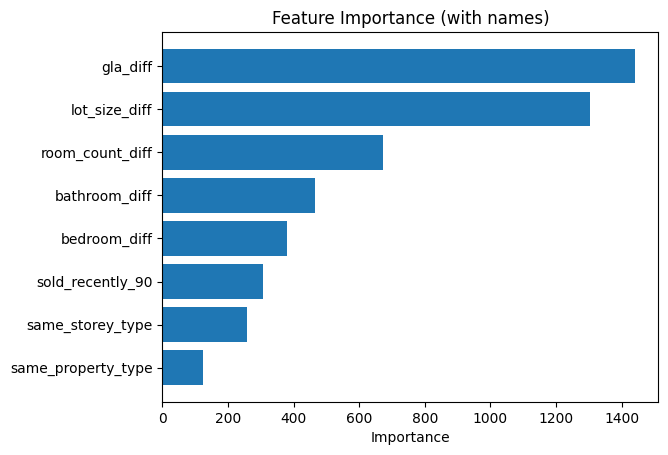

In [94]:
# Map XGBoost f0, f1, ... to your feature columns
feature_names = feature_cols  # This is your list of actual feature names

# Get importances as a dict: keys like 'f0', 'f1', ...
importances = model.get_score(importance_type='weight')

# Map 'f0' -> feature_names[0], etc.
importances_named = {feature_names[int(f[1:])]: importance for f, importance in importances.items()}

# Sort features by importance for nicer plots
sorted_features = sorted(importances_named.items(), key=lambda x: x[1], reverse=True)

# Separate names and values for plotting
names = [x[0] for x in sorted_features]
vals = [x[1] for x in sorted_features]

import matplotlib.pyplot as plt
plt.barh(names, vals)
plt.xlabel('Importance')
plt.title('Feature Importance (with names)')
plt.gca().invert_yaxis()
plt.show()


In [97]:
top3.columns

Index(['orderID', 'subj_gla', 'gla_clean', 'gla_diff', 'subj_lot_size',
       'lot_size_clean', 'lot_size_diff', 'subj_bedrooms', 'bedrooms_clean',
       'bedroom_diff', 'subj_bathrooms', 'bathrooms_clean', 'bathroom_diff',
       'subj_room_count', 'room_count_clean', 'room_count_diff',
       'subj_property_type', 'property_type_clean', 'same_property_type',
       'subj_stories', 'stories_clean', 'same_storey_type', 'sale_date_clean',
       'sold_recently_90', 'sold_recently_180', 'label', 'subj_effective_date',
       'id', 'address', 'bedrooms', 'gla', 'city', 'province', 'postal_code',
       'property_sub_type', 'structure_type', 'style', 'levels', 'room_count',
       'full_baths', 'half_baths', 'main_level_finished_area',
       'upper_lvl_fin_area', 'bg_fin_area', 'lot_size_sf', 'year_built',
       'roof', 'basement', 'cooling', 'heating', 'close_price', 'close_date',
       'public_remarks', 'latitude', 'longitude', 'close_date_clean',
       'full_baths_clean', 'half_ba